In [62]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [63]:
import seaborn as sns
sns.set(style="whitegrid")

## Forward Simulation

Parameters:

In [64]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [65]:
big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

Simulation function

In [66]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(1+4*z) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]


## Visualizing

In [67]:
C, Z, X = sim(10,100)

In [68]:
color = {0:'red', 1:'green', 2: 'blue'}
C_color = [color[c] for c in C]
C_color

['blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue']

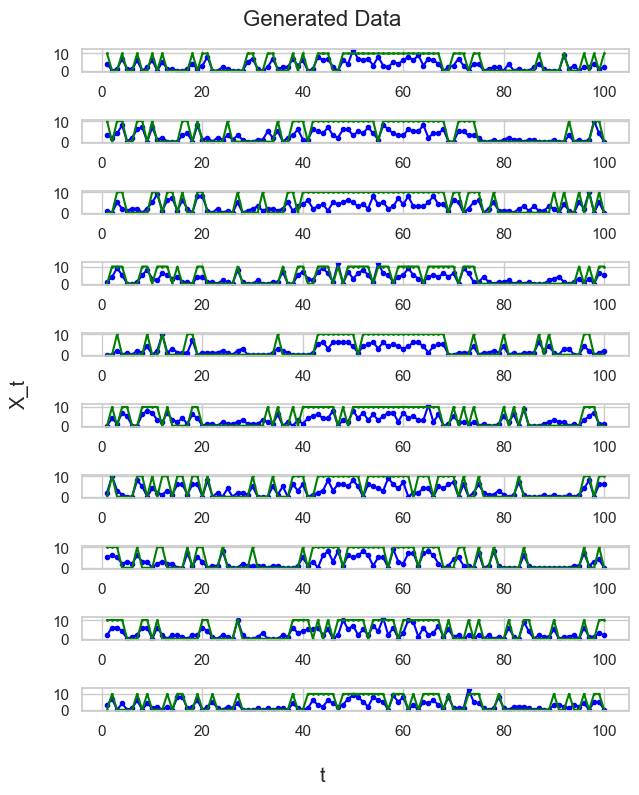

In [69]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[:, i] 
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='blue')
    y_plot_z = [Z[0][i]*10]
    for j in range(1,100):
        y_plot_z.append(Z[j][i]*10)
    axs[i].plot(x_plot, y_plot_z, marker='o', markersize=1, color = 'green')
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [70]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[i,:])

Text(0.5, 1.0, 'Average')

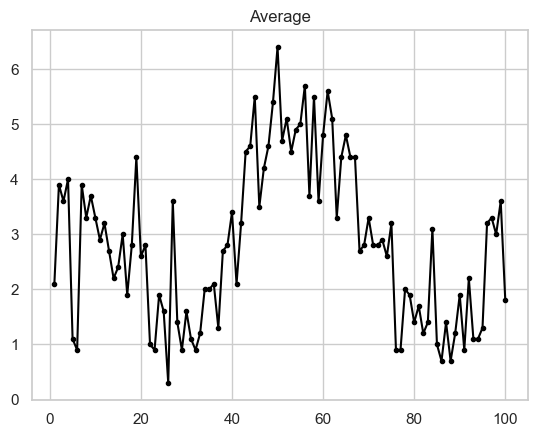

In [71]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')

## Multinomial logistic regression

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [73]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C[i], Z[i], X[i] = sim(n2,T)


In [74]:
X_reg = X.reshape((1000, n2*T))
lr = LogisticRegression(max_iter=5000)
lr.fit(X_reg, C[:,49])

LogisticRegression(max_iter=5000)

Prediction accuracy

In [75]:
np.random.seed(80)
n1 = 1000

C_test, Z_test, X_test = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C_test[i], Z_test[i], X_test[i] = sim(10,100)

X_reg_test = X_test.reshape((1000, 100*10))

np.mean(lr.predict(X_reg_test) == C_test[:,49])


0.668

In [76]:
lr.coef_

array([[ 0.03707576,  0.07556136,  0.02679373, ...,  0.01847613,
        -0.02778083,  0.03911787],
       [-0.06965838, -0.17429022,  0.01776721, ..., -0.01074624,
        -0.03011102, -0.04705927],
       [ 0.03258263,  0.09872886, -0.04456094, ..., -0.00772989,
         0.05789184,  0.0079414 ]])

In [77]:
print(np.mean(lr.coef_[0]), np.mean(lr.coef_[1]), np.mean(lr.coef_[2]))

-0.000813642936020122 -9.472616592041926e-05 0.0009083691019386659


Predict from only certain X's

In [78]:
new_x_reg = X[:,48:51,:]
new_x_reg = new_x_reg.reshape((1000, 10*3))

In [79]:
lr2 = LogisticRegression(max_iter=5000)
lr2.fit(new_x_reg, C[:,49])

LogisticRegression(max_iter=5000)

Accuracy

In [80]:
X_reg_test = X_test[:,48:51,:]
X_reg_test = X_reg_test.reshape((1000, 10*3))

np.mean(lr2.predict(X_reg_test) == C_test[:,49])

0.882

# Inference

In [81]:
import math
from functools import reduce
from itertools import product

In [82]:
n = 3
T = 5
p_zc = np.array([[alpha, 1-alpha],[1-alpha,alpha], [0.5,0.5]]) #(C_i,Z_ij)

p_zc

array([[0.9, 0.1],
       [0.1, 0.9],
       [0.5, 0.5]])

Beliefs

In [83]:
psi_a_1 = np.array([big_gamma[0]*0, big_gamma[1]*0, big_gamma[2]*1]) #(C_1,C_2)
psi_a_i = big_gamma #(C_i,C_i+1) # i = 1,..,T-1
psi_b_i = np.zeros(shape = [3,n+1]) #(C_i, #Z_ij = 1) i = 1,..,T-1, j=1,..,n 
for c_val in range(3):
    psi_b_i[c_val,:] = [(p_zc[c_val,0]**(n-sum_z_ij))*(p_zc[c_val,1]**(sum_z_ij)) for sum_z_ij in range(n+1)]

In [84]:
def psi_c_i(xs):
    def func(zs):
        k = sum(zs)
        lambdas = reduce(lambda x, y: x * y, [lambda_p[z]**x for z,x in zip(zs, xs)])
        factorials = reduce(lambda x,y: x*y, [math.factorial(x) for x in xs])
        exponentials = np.exp( - ((len(zs) - k) * lambda_p[0] + k * lambda_p[1]))
        return exponentials * lambdas / factorials
    return func


Data

In [85]:
C, Z, X = sim(n,T)

In [86]:
X

array([[ 4,  4,  6],
       [ 2,  1,  1],
       [ 0,  3,  2],
       [ 1,  1,  1],
       [ 1,  1, 10]])

Messages: Upwards pass

In [87]:
# Sending messag from C_i clique (consists of X's and Z's) to B_i (consists of Z's and C_i) clique 
delta_ci_bi_list = [None]*T
for i in range(T):
    delta_ci_bi_list[i] = psi_c_i(X[i,:]) # function of Zs

In [88]:
# Sending messag from B_i clique (consists of Z's and C_i) to A_i clique (C_i and C_{i+1}) 
delta_bi_ai_list = np.empty(shape = (T,3)) #(t,C_t) t=1,...,T
for t in range(T):
    for c_val in range(3):
        delta_bi_ai_list[t, c_val] = sum([psi_b_i[c_val,sum(zs)] * delta_ci_bi_list[t](zs) for zs in list(product([0, 1], repeat=n))])

In [89]:
# Sending messag from A_i clique (consists of C_i and C_i+1) to A_i+1 clique (C_i+1 and C_{i+2}) 
delta_ai_i1_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1

for t in range(T-1):
    for c_i_ in range(3):
        if t == 0:
            delta_ai_i1_list[t,c_i_] = sum([psi_a_1[c_i,c_i_] * delta_bi_ai_list[0,c_i] for c_i in [0,1,2]])
        delta_ai_i1_list[t, c_i_] = sum([psi_a_i[c_i,c_i_] * delta_bi_ai_list[t,c_i] for c_i in [0,1,2]])

In [90]:
delta_ai_i1_list

array([[8.01034710e-05, 3.07933582e-03, 8.70365929e-04],
       [1.80552131e-02, 9.22340994e-04, 6.31285085e-03],
       [3.84885888e-03, 7.34500550e-04, 2.47910802e-03],
       [3.44820712e-02, 1.08145842e-03, 1.02472414e-02]])

Downward pass

In [91]:
# Sending message from A_i+1 clique (consists of C_i+1 and C_i+2) to A_i clique (consists of C_i and C_i+1)
delta_ai_i1_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1

for t in range(T-1):
    for c_i_ in range(3):
        if t == T-1:
            delta_ai_i1_list[t,c_i_] = sum([psi_a_1[c_i,c_i_] * delta_bi_ai_list[T-t,c_i] for c_i_ in [0,1,2]])
        delta_ai_i1_list[t, c_i_] = sum([psi_a_i[c_i,c_i_] * delta_bi_ai_list[T-t,c_i]* for c_i_ in [0,1,2]])


SyntaxError: invalid syntax (1995977209.py, line 8)

In [144]:
x = 0
for zs in list(product([0, 1], repeat=n)):
    print(delta_ci_bi[0](zs))
    #print(psi_b_i[:,sum(zs)] @ delta_ci_bi[0](zs))

[       inf 0.00383208 0.00191604]
[        inf 27.41677653 13.70838826]
[       inf 0.04386684 0.02193342]
[         inf 313.84736147 156.92368073]
[           inf 7.01869479e-05 3.50934740e-05]
[       inf 0.50215578 0.25107789]
[       inf 0.00080345 0.00040172]
[       inf 5.74831494 2.87415747]


/var/folders/kq/0f1vjrnj2xn0q3t1270kq05r0000gn/T/ipykernel_8999/532239912.py:6: RuntimeWarning: divide by zero encountered in divide
  exponentials = np.exp(-(1-k)*lambda_p[0]-k*lambda_p[1])*lambdas/xs


In [141]:
sum([psi_b_i[:,sum(zs)] @ delta_ci_bi[0](zs) for zs in list(product([0, 1], repeat=n))])

/var/folders/kq/0f1vjrnj2xn0q3t1270kq05r0000gn/T/ipykernel_8999/532239912.py:6: RuntimeWarning: divide by zero encountered in divide
  exponentials = np.exp(-(1-k)*lambda_p[0]-k*lambda_p[1])*lambdas/xs


inf

In [143]:
delta_ci_bi[0]

<function __main__.psi_i_c.<locals>.func(zs)>